In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from keras.optimizers import Adam
from keras.models import Sequential
from keras.callbacks import EarlyStopping
from keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.preprocessing.text import Tokenizer
from sklearn.model_selection import train_test_split, StratifiedKFold
from keras.layers import Embedding, LSTM, Dropout, Dense, GRU, SimpleRNN, Flatten

from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score


In [45]:
df = pd.read_csv('../data/train.csv')

In [46]:
texts = df['text'].astype(str)
relevance = df['positive']
X_train, X_test, y_train, y_test = train_test_split(texts, relevance, test_size=0.15, random_state=42, shuffle=True)

In [47]:
max_words = 5000
tokenizer = Tokenizer(num_words=max_words)
tokenizer.fit_on_texts(X_train)

In [48]:
sequences_train = tokenizer.texts_to_sequences(X_train)
sequences_test = tokenizer.texts_to_sequences(X_test)

In [49]:
# Padding
maxlen = 100 
X_train = pad_sequences(sequences_train, maxlen=maxlen)
y_train = np.array(y_train)

X_test = pad_sequences(sequences_test, maxlen=maxlen)
y_test = np.array(y_test)


In [50]:
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.15, random_state=42)

In [51]:
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

Создадим функцию для тестирования моделей

In [52]:
def create_plot(history):
    plt.plot(
        history.history['loss'],
        label='Train loss'
        )
    plt.plot(
        history.history['val_loss'], 
        label='Val loss'
        )
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.xticks(range(1, 11))
    plt.legend()
    plt.show()

def calculate_metrics(y_pred, y_test):
    accuracy = accuracy_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred)
    recall = recall_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred)

    print('Test accuracy is {}'.format(accuracy))
    print('Test precision is {}'.format(precision))
    print('Test recall is {}'.format(recall))
    print('Test f1 is {}'.format(f1))


def compile_fit_model(model, X_train, y_train, X_val, y_val):
    model.compile(
        optimizer=Adam(),
        loss='binary_crossentropy',
        metrics=['accuracy']
        )
    history = model.fit(
        X_train, y_train,
        epochs=10,
        batch_size=32,
        callbacks=[early_stopping],
        validation_data=(X_val, y_val),
        shuffle=False
        )
    return history

def test_model(model, X_train, y_train, X_test, y_test, X_val, y_val, threshold=0.5):
    """Trains and tests a given model.

    Args:
        model: The model to be trained and tested.
        X_train: Training features.
        y_train: Training labels.
        X_test: Test features.
        y_test: Test labels.
        X_val: Validation features.
        y_val: Validation labels.
        threshold: Threshold for converting probabilities to binary predictions.

    Returns:
        None
    """
        
    history = compile_fit_model(model, X_train, y_train, X_val, y_val)
    create_plot(history)
    y_pred = model.predict(X_test)
    y_pred = (y_pred > threshold).astype(int)
    calculate_metrics(y_pred, y_test)



Попробуем сначала реализовать простую модель

Epoch 1/10
565/565 ━━━━━━━━━━━━━━━━━━━━ 6s 6ms/step - accuracy: 0.6516 - loss: 0.6313 - val_accuracy: 0.8501 - val_loss: 0.3626
Epoch 2/10
565/565 ━━━━━━━━━━━━━━━━━━━━ 3s 5ms/step - accuracy: 0.8711 - loss: 0.3147 - val_accuracy: 0.8532 - val_loss: 0.3360
Epoch 3/10
565/565 ━━━━━━━━━━━━━━━━━━━━ 3s 5ms/step - accuracy: 0.9229 - loss: 0.2178 - val_accuracy: 0.8485 - val_loss: 0.3504
Epoch 4/10
565/565 ━━━━━━━━━━━━━━━━━━━━ 3s 5ms/step - accuracy: 0.9608 - loss: 0.1407 - val_accuracy: 0.8432 - val_loss: 0.3770
Epoch 5/10
565/565 ━━━━━━━━━━━━━━━━━━━━ 3s 5ms/step - accuracy: 0.9876 - loss: 0.0806 - val_accuracy: 0.8372 - val_loss: 0.4091
Epoch 6/10
565/565 ━━━━━━━━━━━━━━━━━━━━ 3s 5ms/step - accuracy: 0.9970 - loss: 0.0436 - val_accuracy: 0.8366 - val_loss: 0.4446
Epoch 7/10
565/565 ━━━━━━━━━━━━━━━━━━━━ 3s 5ms/step - accuracy: 0.9995 - loss: 0.0239 - val_accuracy: 0.8344 - val_loss: 0.4800


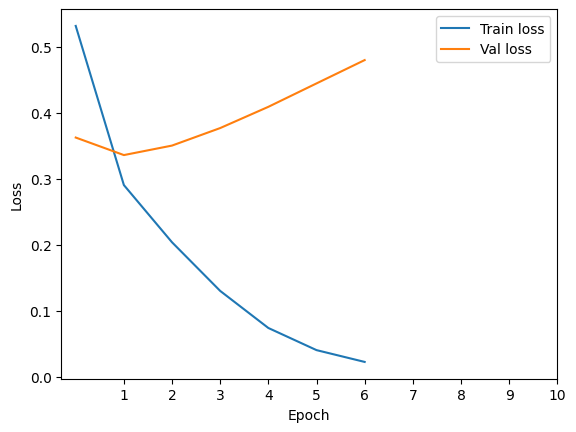

118/118 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step
Test accuracy is 0.8610666666666666
Test precision is 0.8486676721970839
Test recall is 0.8846960167714885
Test f1 is 0.8663074159609957


In [11]:
model_base = Sequential()
model_base.add(Embedding(max_words, 25))
model_base.add(Flatten())
model_base.add(Dense(1, activation='sigmoid'))

test_model(model_base, X_train, y_train, X_test, y_test, X_val, y_val)

Модель показывает неплохое качество, при этом precision и recall довольно сбалансированы и близки друг к другу.

Попробуем далее усложнить модель.

Epoch 1/10
565/565 ━━━━━━━━━━━━━━━━━━━━ 6s 6ms/step - accuracy: 0.6490 - loss: 0.6288 - val_accuracy: 0.8476 - val_loss: 0.3590
Epoch 2/10
565/565 ━━━━━━━━━━━━━━━━━━━━ 3s 6ms/step - accuracy: 0.8764 - loss: 0.3091 - val_accuracy: 0.8526 - val_loss: 0.3344
Epoch 3/10
565/565 ━━━━━━━━━━━━━━━━━━━━ 3s 5ms/step - accuracy: 0.9273 - loss: 0.2048 - val_accuracy: 0.8469 - val_loss: 0.3500
Epoch 4/10
565/565 ━━━━━━━━━━━━━━━━━━━━ 3s 5ms/step - accuracy: 0.9705 - loss: 0.1198 - val_accuracy: 0.8400 - val_loss: 0.3787
Epoch 5/10
565/565 ━━━━━━━━━━━━━━━━━━━━ 4s 6ms/step - accuracy: 0.9932 - loss: 0.0608 - val_accuracy: 0.8347 - val_loss: 0.4165
Epoch 6/10
565/565 ━━━━━━━━━━━━━━━━━━━━ 3s 5ms/step - accuracy: 0.9987 - loss: 0.0308 - val_accuracy: 0.8331 - val_loss: 0.4566
Epoch 7/10
565/565 ━━━━━━━━━━━━━━━━━━━━ 3s 5ms/step - accuracy: 0.9996 - loss: 0.0166 - val_accuracy: 0.8297 - val_loss: 0.4893


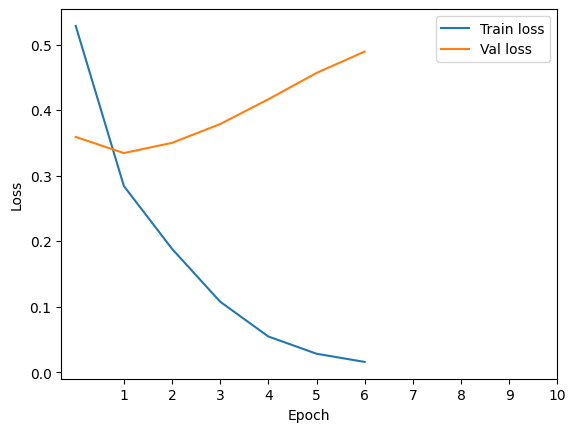

118/118 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step
Test accuracy is 0.864
Test precision is 0.8573619631901841
Test recall is 0.8789308176100629
Test f1 is 0.8680124223602486


In [54]:
model_base2 = Sequential()
model_base2.add(Embedding(max_words, 30))
model_base2.add(Flatten())
model_base2.add(Dense(1, activation='sigmoid'))

test_model(model_base2, X_train, y_train, X_test, y_test, X_val, y_val)

Epoch 1/10
565/565 ━━━━━━━━━━━━━━━━━━━━ 6s 7ms/step - accuracy: 0.6494 - loss: 0.6203 - val_accuracy: 0.8526 - val_loss: 0.3498
Epoch 2/10
565/565 ━━━━━━━━━━━━━━━━━━━━ 3s 6ms/step - accuracy: 0.8821 - loss: 0.2954 - val_accuracy: 0.8541 - val_loss: 0.3352
Epoch 3/10
565/565 ━━━━━━━━━━━━━━━━━━━━ 3s 5ms/step - accuracy: 0.9438 - loss: 0.1763 - val_accuracy: 0.8457 - val_loss: 0.3563
Epoch 4/10
565/565 ━━━━━━━━━━━━━━━━━━━━ 3s 6ms/step - accuracy: 0.9866 - loss: 0.0829 - val_accuracy: 0.8457 - val_loss: 0.3870
Epoch 5/10
565/565 ━━━━━━━━━━━━━━━━━━━━ 3s 5ms/step - accuracy: 0.9986 - loss: 0.0354 - val_accuracy: 0.8347 - val_loss: 0.4378
Epoch 6/10
565/565 ━━━━━━━━━━━━━━━━━━━━ 4s 6ms/step - accuracy: 0.9994 - loss: 0.0172 - val_accuracy: 0.8381 - val_loss: 0.4648
Epoch 7/10
565/565 ━━━━━━━━━━━━━━━━━━━━ 4s 6ms/step - accuracy: 1.0000 - loss: 0.0093 - val_accuracy: 0.8369 - val_loss: 0.5040


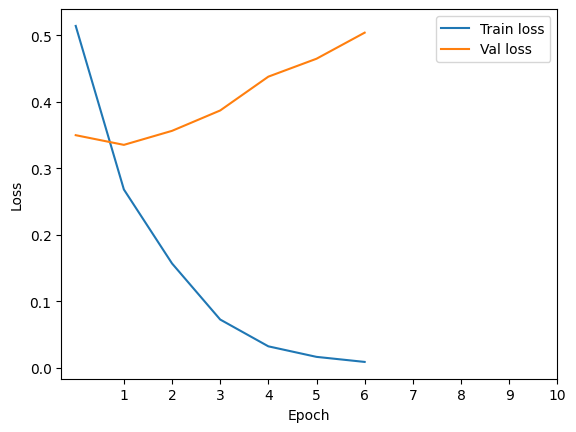

118/118 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
Test accuracy is 0.8557333333333333
Test precision is 0.8429503261414952
Test recall is 0.8805031446540881
Test f1 is 0.8613176108690079


In [53]:
model_base3 = Sequential()
model_base3.add(Embedding(max_words, 45))
model_base3.add(Flatten())
model_base3.add(Dense(1, activation='sigmoid'))

test_model(model_base3, X_train, y_train, X_test, y_test, X_val, y_val)

Модель становится лучше для 2 модели, и хуже для 3

Попробуем рекурентные нейросети, которые часто хорошо подходят для классификации текстов.

Epoch 1/10
565/565 ━━━━━━━━━━━━━━━━━━━━ 24s 34ms/step - accuracy: 0.5682 - loss: 0.6699 - val_accuracy: 0.8077 - val_loss: 0.4431
Epoch 2/10
565/565 ━━━━━━━━━━━━━━━━━━━━ 19s 33ms/step - accuracy: 0.8167 - loss: 0.4188 - val_accuracy: 0.8338 - val_loss: 0.3908
Epoch 3/10
565/565 ━━━━━━━━━━━━━━━━━━━━ 18s 32ms/step - accuracy: 0.8798 - loss: 0.3031 - val_accuracy: 0.8309 - val_loss: 0.3983
Epoch 4/10
565/565 ━━━━━━━━━━━━━━━━━━━━ 18s 31ms/step - accuracy: 0.9169 - loss: 0.2285 - val_accuracy: 0.8372 - val_loss: 0.4079
Epoch 5/10
565/565 ━━━━━━━━━━━━━━━━━━━━ 18s 31ms/step - accuracy: 0.9442 - loss: 0.1653 - val_accuracy: 0.8325 - val_loss: 0.4630


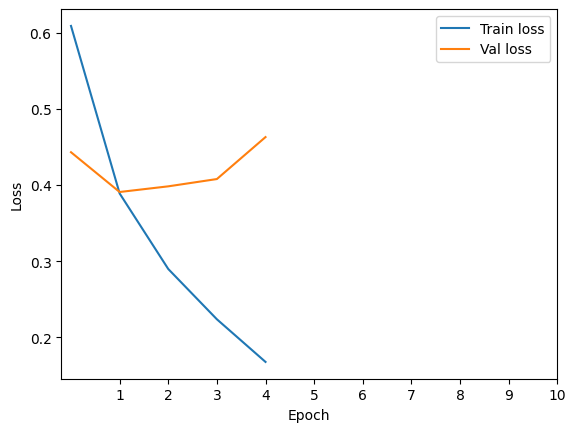

118/118 ━━━━━━━━━━━━━━━━━━━━ 2s 11ms/step
Test accuracy is 0.8072
Test precision is 0.8194070080862533
Test recall is 0.7966457023060797
Test f1 is 0.8078660643103905


In [14]:
model_rnn_base = Sequential()
model_rnn_base.add(Embedding(max_words, 15))
model_rnn_base.add(SimpleRNN(12))
model_rnn_base.add(Dense(1, activation='sigmoid'))

test_model(model_rnn_base, X_train, y_train, X_test, y_test, X_val, y_val)

Модель показывает результат хуже

Epoch 1/10
565/565 ━━━━━━━━━━━━━━━━━━━━ 25s 34ms/step - accuracy: 0.6148 - loss: 0.6465 - val_accuracy: 0.6650 - val_loss: 0.6024
Epoch 2/10
565/565 ━━━━━━━━━━━━━━━━━━━━ 18s 31ms/step - accuracy: 0.7874 - loss: 0.4778 - val_accuracy: 0.8065 - val_loss: 0.4393
Epoch 3/10
565/565 ━━━━━━━━━━━━━━━━━━━━ 18s 31ms/step - accuracy: 0.8568 - loss: 0.3487 - val_accuracy: 0.8099 - val_loss: 0.4508
Epoch 4/10
565/565 ━━━━━━━━━━━━━━━━━━━━ 19s 33ms/step - accuracy: 0.9045 - loss: 0.2563 - val_accuracy: 0.7964 - val_loss: 0.5096
Epoch 5/10
565/565 ━━━━━━━━━━━━━━━━━━━━ 19s 34ms/step - accuracy: 0.9295 - loss: 0.1917 - val_accuracy: 0.7996 - val_loss: 0.5562


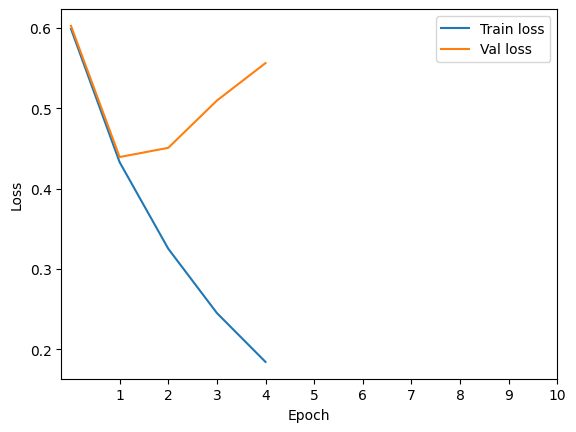

118/118 ━━━━━━━━━━━━━━━━━━━━ 2s 11ms/step
Test accuracy is 0.652
Test precision is 0.8860435339308579
Test recall is 0.36268343815513626
Test f1 is 0.5146894756415024


In [15]:
model_rnn2 = Sequential()
model_rnn2.add(Embedding(max_words, 15))
model_rnn2.add(SimpleRNN(12))
model_rnn2.add(Dropout(0.25))
model_rnn2.add(Dense(1, activation='sigmoid'))

test_model(model_rnn2, X_train, y_train, X_test, y_test, X_val, y_val)

Дропаут слой делает только хуже.

Epoch 1/10
565/565 ━━━━━━━━━━━━━━━━━━━━ 23s 33ms/step - accuracy: 0.5679 - loss: 0.6723 - val_accuracy: 0.7961 - val_loss: 0.4464
Epoch 2/10
565/565 ━━━━━━━━━━━━━━━━━━━━ 18s 32ms/step - accuracy: 0.8058 - loss: 0.4471 - val_accuracy: 0.8243 - val_loss: 0.4101
Epoch 3/10
565/565 ━━━━━━━━━━━━━━━━━━━━ 17s 30ms/step - accuracy: 0.8527 - loss: 0.3694 - val_accuracy: 0.8196 - val_loss: 0.4066
Epoch 4/10
565/565 ━━━━━━━━━━━━━━━━━━━━ 18s 32ms/step - accuracy: 0.8892 - loss: 0.3018 - val_accuracy: 0.8174 - val_loss: 0.4202
Epoch 5/10
565/565 ━━━━━━━━━━━━━━━━━━━━ 18s 32ms/step - accuracy: 0.9093 - loss: 0.2498 - val_accuracy: 0.8221 - val_loss: 0.4558


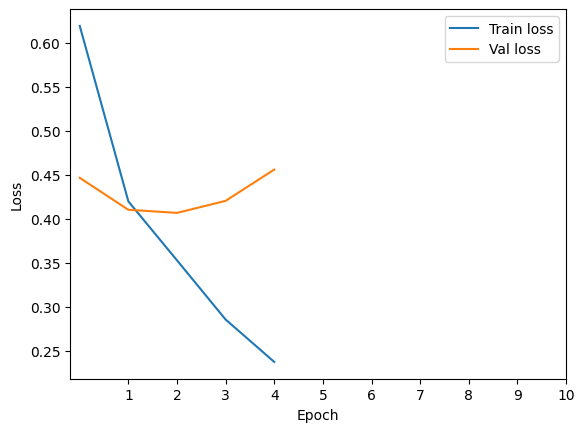

118/118 ━━━━━━━━━━━━━━━━━━━━ 2s 11ms/step
Test accuracy is 0.7944
Test precision is 0.8153078202995009
Test recall is 0.7704402515723271
Test f1 is 0.7922392886014551


In [16]:
model_rnn3 = Sequential()
model_rnn3.add(Embedding(max_words, 15))
model_rnn3.add(SimpleRNN(12))
model_rnn3.add(Dropout(0.5))
model_rnn3.add(Dense(1, activation='sigmoid'))

test_model(model_rnn3, X_train, y_train, X_test, y_test, X_val, y_val)

Попробуем модель GRU

Epoch 1/10
565/565 ━━━━━━━━━━━━━━━━━━━━ 36s 54ms/step - accuracy: 0.6345 - loss: 0.6203 - val_accuracy: 0.8347 - val_loss: 0.3921
Epoch 2/10
565/565 ━━━━━━━━━━━━━━━━━━━━ 29s 52ms/step - accuracy: 0.8507 - loss: 0.3620 - val_accuracy: 0.8460 - val_loss: 0.3683
Epoch 3/10
565/565 ━━━━━━━━━━━━━━━━━━━━ 30s 52ms/step - accuracy: 0.8913 - loss: 0.2957 - val_accuracy: 0.8388 - val_loss: 0.3737
Epoch 4/10
565/565 ━━━━━━━━━━━━━━━━━━━━ 30s 52ms/step - accuracy: 0.9085 - loss: 0.2630 - val_accuracy: 0.8407 - val_loss: 0.3817
Epoch 5/10
565/565 ━━━━━━━━━━━━━━━━━━━━ 30s 53ms/step - accuracy: 0.9128 - loss: 0.2464 - val_accuracy: 0.8400 - val_loss: 0.4063


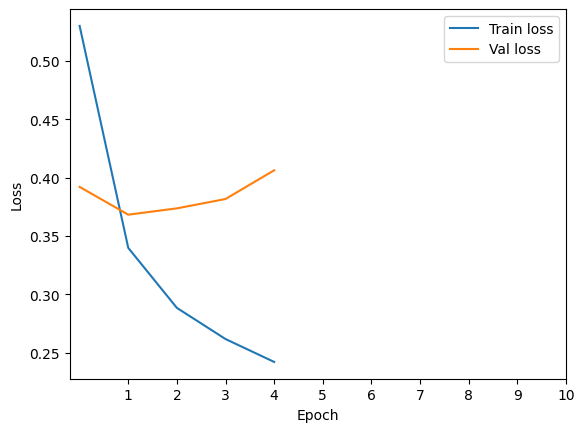

118/118 ━━━━━━━━━━━━━━━━━━━━ 3s 20ms/step
Test accuracy is 0.8386666666666667
Test precision is 0.869540555870675
Test recall is 0.8034591194968553
Test f1 is 0.8351947698174884


In [17]:
model_gru_base = Sequential()
model_gru_base.add(Embedding(max_words, 15))
model_gru_base.add(GRU(12))
model_gru_base.add(Dropout(0.5))
model_gru_base.add(Dense(1, activation='sigmoid'))

test_model(model_gru_base, X_train, y_train, X_test, y_test, X_val, y_val)

Модель показывает метрики хуже, чем базовая модель

Epoch 1/10
565/565 ━━━━━━━━━━━━━━━━━━━━ 31s 47ms/step - accuracy: 0.6787 - loss: 0.5815 - val_accuracy: 0.8460 - val_loss: 0.3671
Epoch 2/10
565/565 ━━━━━━━━━━━━━━━━━━━━ 27s 48ms/step - accuracy: 0.8675 - loss: 0.3255 - val_accuracy: 0.8485 - val_loss: 0.3512
Epoch 3/10
565/565 ━━━━━━━━━━━━━━━━━━━━ 25s 44ms/step - accuracy: 0.8998 - loss: 0.2618 - val_accuracy: 0.8422 - val_loss: 0.3743
Epoch 4/10
565/565 ━━━━━━━━━━━━━━━━━━━━ 25s 43ms/step - accuracy: 0.9180 - loss: 0.2201 - val_accuracy: 0.8369 - val_loss: 0.4061
Epoch 5/10
565/565 ━━━━━━━━━━━━━━━━━━━━ 25s 45ms/step - accuracy: 0.9284 - loss: 0.1968 - val_accuracy: 0.8407 - val_loss: 0.4239


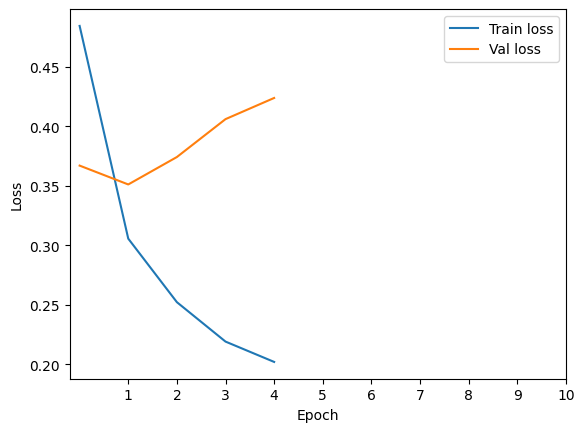

118/118 ━━━━━━━━━━━━━━━━━━━━ 3s 21ms/step
Test accuracy is 0.8488
Test precision is 0.861455525606469
Test recall is 0.8375262054507338
Test f1 is 0.8493223491894765


In [18]:
model_lstm_base = Sequential()
model_lstm_base.add(Embedding(max_words, 15))
model_lstm_base.add(LSTM(12))
model_lstm_base.add(Dense(1, activation='sigmoid'))

test_model(model_lstm_base, X_train, y_train, X_test, y_test, X_val, y_val)

Модель также хуже, чем базовая, еще и обучается дольше

Ситуация аналогична GRU

Epoch 1/10
565/565 ━━━━━━━━━━━━━━━━━━━━ 29s 42ms/step - accuracy: 0.6718 - loss: 0.6142 - val_accuracy: 0.8363 - val_loss: 0.4092
Epoch 2/10
565/565 ━━━━━━━━━━━━━━━━━━━━ 23s 41ms/step - accuracy: 0.8577 - loss: 0.3603 - val_accuracy: 0.8450 - val_loss: 0.3720
Epoch 3/10
565/565 ━━━━━━━━━━━━━━━━━━━━ 30s 52ms/step - accuracy: 0.8925 - loss: 0.2842 - val_accuracy: 0.8363 - val_loss: 0.3871
Epoch 4/10
565/565 ━━━━━━━━━━━━━━━━━━━━ 24s 42ms/step - accuracy: 0.9104 - loss: 0.2423 - val_accuracy: 0.8356 - val_loss: 0.3976
Epoch 5/10
565/565 ━━━━━━━━━━━━━━━━━━━━ 25s 45ms/step - accuracy: 0.9281 - loss: 0.2079 - val_accuracy: 0.8400 - val_loss: 0.4196


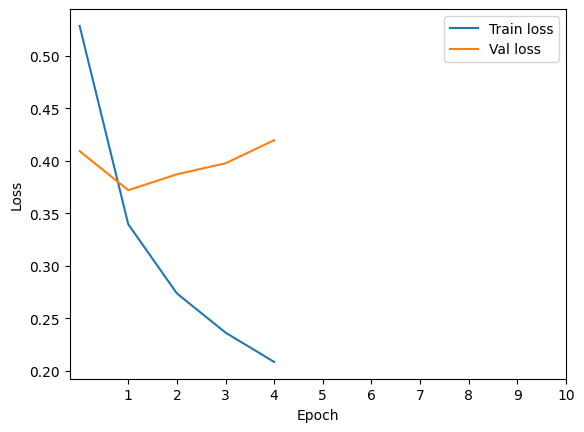

118/118 ━━━━━━━━━━━━━━━━━━━━ 2s 16ms/step
Test accuracy is 0.8365333333333334
Test precision is 0.8332475553268142
Test recall is 0.8485324947589099
Test f1 is 0.8408205660867307


In [19]:
model_lstm2 = Sequential()
model_lstm2.add(Embedding(max_words, 15))
model_lstm2.add(LSTM(6))
model_lstm2.add(Dense(1, activation='sigmoid'))

test_model(model_lstm2, X_train, y_train, X_test, y_test, X_val, y_val)

Снижение числа нейронов слоя LSTM не дает нужного эффекта, модель хуже чем базовая, однако обучается дольше.

Попробуем несколько слоев LSTM

Epoch 1/10
565/565 ━━━━━━━━━━━━━━━━━━━━ 56s 85ms/step - accuracy: 0.6666 - loss: 0.6032 - val_accuracy: 0.8071 - val_loss: 0.4414
Epoch 2/10
565/565 ━━━━━━━━━━━━━━━━━━━━ 47s 83ms/step - accuracy: 0.8417 - loss: 0.3978 - val_accuracy: 0.8353 - val_loss: 0.3824
Epoch 3/10
565/565 ━━━━━━━━━━━━━━━━━━━━ 47s 82ms/step - accuracy: 0.8817 - loss: 0.3126 - val_accuracy: 0.8476 - val_loss: 0.3667
Epoch 4/10
565/565 ━━━━━━━━━━━━━━━━━━━━ 48s 84ms/step - accuracy: 0.9096 - loss: 0.2625 - val_accuracy: 0.8457 - val_loss: 0.3908
Epoch 5/10
565/565 ━━━━━━━━━━━━━━━━━━━━ 48s 84ms/step - accuracy: 0.9208 - loss: 0.2276 - val_accuracy: 0.8359 - val_loss: 0.4516


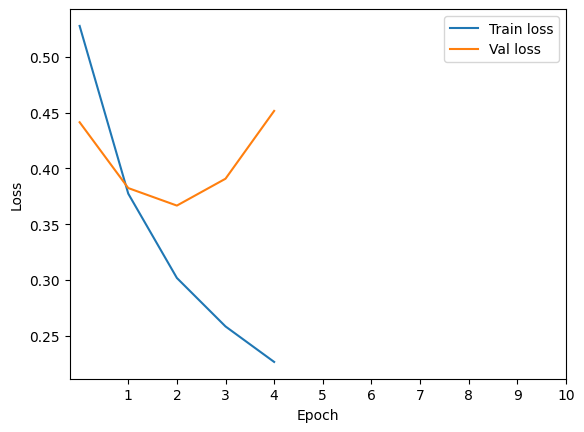

118/118 ━━━━━━━━━━━━━━━━━━━━ 4s 30ms/step
Test accuracy is 0.8130666666666667
Test precision is 0.7746927628584434
Test recall is 0.8920335429769392
Test f1 is 0.8292326431181487


In [20]:
model_lstm3 = Sequential()
model_lstm3.add(Embedding(max_words, 30))
model_lstm3.add(LSTM(6, return_sequences=True))
model_lstm3.add(Dropout(0.25))
model_lstm3.add(LSTM(6))
model_lstm3.add(Dropout(0.25))
model_lstm3.add(Dense(1, activation='sigmoid'))

test_model(model_lstm3, X_train, y_train, X_test, y_test, X_val, y_val)

Качество выросло незаметно

Попробуем полносвязную нейросеть

Epoch 1/10
565/565 ━━━━━━━━━━━━━━━━━━━━ 7s 7ms/step - accuracy: 0.5261 - loss: 0.6872 - val_accuracy: 0.7914 - val_loss: 0.5035
Epoch 2/10
565/565 ━━━━━━━━━━━━━━━━━━━━ 3s 5ms/step - accuracy: 0.7991 - loss: 0.4959 - val_accuracy: 0.8187 - val_loss: 0.4174
Epoch 3/10
565/565 ━━━━━━━━━━━━━━━━━━━━ 3s 5ms/step - accuracy: 0.8833 - loss: 0.3429 - val_accuracy: 0.8303 - val_loss: 0.4419
Epoch 4/10
565/565 ━━━━━━━━━━━━━━━━━━━━ 3s 5ms/step - accuracy: 0.9324 - loss: 0.2256 - val_accuracy: 0.8316 - val_loss: 0.6008
Epoch 5/10
565/565 ━━━━━━━━━━━━━━━━━━━━ 3s 6ms/step - accuracy: 0.9606 - loss: 0.1538 - val_accuracy: 0.8275 - val_loss: 0.7211


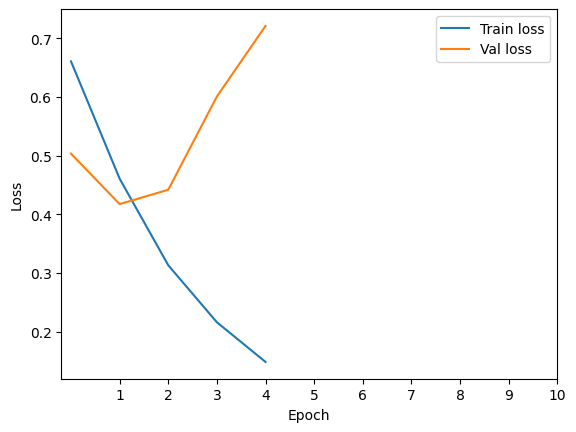

118/118 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step
Test accuracy is 0.7976
Test precision is 0.8100377765785213
Test recall is 0.7866876310272537
Test f1 is 0.7981919702206859


In [21]:
model_fully = Sequential()
model_fully.add(Embedding(max_words, 30))
model_fully.add(Flatten())
model_fully.add(Dense(10, activation='relu'))
model_fully.add(Dropout(0.5))
model_fully.add(Dense(10, activation='relu'))
model_fully.add(Dropout(0.5))
model_fully.add(Dense(1, activation='sigmoid'))

test_model(model_fully, X_train, y_train, X_test, y_test, X_val, y_val)

Переобучение и наивный прогноз

Проведем кросс валидацию базовой модели.
Легко можем себе это позволить, так как модель простая и учится очень быстро.
А если можем себе позволить, то почему бы и не сделать.

In [22]:
def cross_validate(
        model, X, y,
        loss_function = 'binary_crossentropy', 
        threshold=0.5, no_epochs=10,
        batch_size=32, max_words=5000,
        optimizer='adam'
        
        ) -> None:

    """
    Выполняет 5-кратную кросс-валидацию для классификационной модели, используя встраивание для векторизации текста.

    Аргументы:
        model: Классификационная модель, которую нужно обучить.
        X_train: Массив обучающих данных (текстовые данные).
        X_test: Массив тестовых данных (текстовые данные).
        y_train: Вектор меток классов для обучающих данных.
        y_test: Вектор меток классов для тестовых данных.

    Возвращает:
        None. Печатает результаты кросс-валидации в консоль.
    """

    # Определяем контейнеры для оценки по каждому фолду
    f1_per_fold = []
    accuracy_per_fold = []
    recall_score_per_fold = []
    precison_score_per_fold = []

    # Объединяем входные данные и целевые значения
    inputs = np.array(X)
    targets = np.array(y)

    # Определение K-кратногокросс-валидатора
    kfold = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
    
    early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

    # Оценка модели с помощью K-кратной кросс-валидации
    fold_no = 1
    for train, test in kfold.split(inputs, targets):
        tokenizer = Tokenizer(num_words=max_words)
        tokenizer.fit_on_texts(inputs[train])
        sequences_train = tokenizer.texts_to_sequences(inputs[train])
        sequences_test = tokenizer.texts_to_sequences(inputs[test])
        
        X_train = pad_sequences(sequences_train, maxlen=maxlen)
        y_train = np.array(targets[train])

        X_test = pad_sequences(sequences_test, maxlen=maxlen)
        y_test = np.array(targets[test])

        X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.15, random_state=42)

        model.compile(
            loss=loss_function,
            optimizer=optimizer,
            metrics=['accuracy']
            )

        print('------------------------------------------------------------------------')
        print(f'Training for fold {fold_no} ...')

        model.fit(
            X_train, y_train,
            epochs=no_epochs,
            batch_size=batch_size,
            callbacks=[early_stopping],
            validation_data=(X_val, y_val),
            shuffle=False
            )

        # Генерируем метрики
        y_pred = model.predict(X_test)
        y_pred = (y_pred > threshold).astype(int)
        
        accuracy_per_fold.append(accuracy_score(y_test, y_pred))
        f1_per_fold.append(f1_score(y_test, y_pred))
        precison_score_per_fold.append(precision_score(y_test, y_pred))
        recall_score_per_fold.append(recall_score(y_test, y_pred))
        
        # Увеличиваем номер фолда
        fold_no = fold_no + 1

    # == Выводим средние оценки ==
    print('------------------------------------------------------------------------')
    print('Score per fold')
    for i in range(0, len(f1_per_fold)):
        print('------------------------------------------------------------------------')
        print(
            f'''
            > Fold {i+1}
            - F1: {f1_per_fold[i]}
            - Precision: {precison_score_per_fold[i]}
            - Recall: {recall_score_per_fold[i]}
            ''')
    print('------------------------------------------------------------------------')
    print('Average scores for all folds:')
    print(f'> Accuracy: {np.mean(f1_per_fold)} (+- {np.std(f1_per_fold)})')
    print(f'> F1: {np.mean(f1_per_fold)} (+- {np.std(f1_per_fold)})')
    print(f'> Precision: {np.mean(precison_score_per_fold)} (+- {np.std(precison_score_per_fold)})')
    print(f'> Recall: {np.mean(recall_score_per_fold)} (+- {np.std(recall_score_per_fold)})')
    print('------------------------------------------------------------------------')


Проверим модель на тесте

In [55]:
df_test = pd.read_csv('../data/test.csv')

In [56]:
texts_test = df_test['text'].astype(str)
labels_test = df_test['positive']

In [57]:
sequences_test = tokenizer.texts_to_sequences(texts_test) #Уже обученный на трейн текстах токенизатор

X_test = pad_sequences(sequences_test, maxlen=maxlen)
y_test = np.array(labels_test)

In [58]:
y_pred = model_base2.predict(X_test)
y_pred = (y_pred > 0.5).astype(int)

782/782 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step


In [59]:
calculate_metrics(y_pred, y_test)

Test accuracy is 0.85464
Test precision is 0.8444444444444444
Test recall is 0.86944
Test f1 is 0.8567599527000394


Модель показала неплохой результат на тесте, по нашей целевой метрике Accuracy тоже неплохо = 0.855,<br><br/>F1 также довольно хороший = 0.857

В итоге наилучшей моделью оказалась простая модель нейросети, состоящая из слоя эмбеддинга и выходного слоя.
